In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sonalshinde123/whatsapp-user-reviews-dataset")

print("Path to dataset files:", path)

100%|██████████| 313k/313k [00:00<00:00, 82.0MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/sonalshinde123/whatsapp-user-reviews-dataset/versions/1


In [ ]:
import pandas as pd
import littlelearn as ll
from littlelearn import DeepLearning as dl
from littlelearn.DeepLearning import layers as ln
import jax

In [ ]:
df = pd.read_csv(path + '/whatsapp_reviews.csv')
df.head()

,review_id,rating,review_text,review_date,helpful
0,56887e3c-1684-4ced-834e-befc7a66fc7d,5,Great 👍,11/26/2025 22:08,0
1,0da4488e-7158-4ea6-bcb9-17b9b3867642,1,plz whats up unban,11/26/2025 22:08,0
2,5a20e8e3-9e00-4360-a539-16953e309a3a,1,my contact didn't show on WhatsApp .. for priv...,11/26/2025 22:06,0
3,0cf26263-1c10-473e-ae15-d6390884fef7,1,Can you guys let archived group chats stay arc...,11/26/2025 22:05,1
4,54eebd96-041e-4baf-a8f1-adf603658c28,5,it is the g.o.a.t🇿🇼,11/26/2025 22:04,0


In [ ]:
tokenizer = ll.preprocessing.Tokenizer()
tokenizer.fit_on_texts(['bos','eos'])
tokenizer.fit_on_texts(df['review_text'].to_list())

tokenizer.len_vocab

5325

In [ ]:
x_train = ['bos ' + s for s in df['review_text'].to_list()]
y_train = [s + ' eos' for s in df['review_text'].to_list()]
x_train = tokenizer.texts_to_sequences(x_train)
y_train = tokenizer.texts_to_sequences(y_train)

In [ ]:
x_train = ll.preprocessing.pad_sequence(x_train)
y_train = ll.preprocessing.pad_sequence(y_train)

In [ ]:
class Dataset(ll.preprocessing.Dataset) :
  def __init__ (self) :
    super().__init__()
    self.x = x_train
    self.y = y_train

  def __getitem__(self, idx) :
    return self.x[idx], self.y[idx]

  def __len__(self) :
    return self.x.shape[0]

# lets ignoring the training with dataset first and focussed at logits interaction, math formula and gradient effect

In [ ]:
import math
import matplotlib.pyplot as plt

In [ ]:
x_sample = x_train[0]
y_sample = y_train[0]

In [ ]:
class Classic_LMA_Naiveformula (ln.Component) :
  def __init__ (self,embed_dim) :
    super().__init__()
    std = math.sqrt(2/(embed_dim * 2))
    self.wg = ln.Parameter(
        tensor= ll.normal(mean=0,std=std,shape=(embed_dim,embed_dim))
    )
    self.wv = ln.Parameter(
        tensor= ll.normal(mean=0,std=std,shape=(embed_dim,embed_dim))
    )
    self.wo = ln.Parameter(
        tensor= ll.normal(mean=0,std=std,shape=(embed_dim,embed_dim))
    )


  def forwardpass(self,Q,K,V,mask = None ) :
    lm = Q + K + V
    lm = ll.matmul(lm,self.wg)
    v = ll.matmul(V,self.wv)
    score = ll.matmul(lm,K,transpose_b=True) / K.shape[-1] ** 0.5
    if mask is not None :
      score = score + mask

    score = dl.activations.softmax(score,axis=-1,keepdims=True,use_crossentropy=False)
    attn = ll.matmul(score,v)
    attn = ll.matmul(attn,self.wo)
    return attn

class LMA_naiveFormula2 (ln.Component) :
  def __init__ (self,embed_dim) :
    super().__init__()
    std = math.sqrt(2/(embed_dim * 2))
    self.wg = ln.Parameter(
        tensor= ll.normal(mean=0,std=std,shape=(embed_dim,embed_dim))

    )
    self.wo = ln.Parameter(
        tensor = ll.normal(mean=0,std=std,shape=(embed_dim,embed_dim))
    )

  def forwardpass(self,Q,K,V,mask = None ) :
    lm = Q + K + V
    lm = ll.matmul(lm,self.wg)
    score = ll.matmul(lm,K,transpose_b=True) / K.shape[-1] ** 0.5
    if mask is not None :
      score = score + mask
    score = dl.activations.softmax(score,axis=-1,keepdims=True,use_crossentropy=False)
    attn = ll.matmul(score,V)
    attn = ll.matmul(attn,self.wo)
    return attn

In [ ]:
logits =  ll.rand(1,10,32) * 32 **0.5
pos_encod = ll.randn((1,10,32)) * 0.2
logits += pos_encod

In [ ]:
lma_naive1 = Classic_LMA_Naiveformula(32)
lma_naive2 = LMA_naiveFormula2(32)
layernorm1 = ln.LayerNorm(32)
layernorm2 = ln.LayerNorm(32)

In [ ]:
naive1_attention = lma_naive1(logits,logits,logits)
naive2_attention = lma_naive2(logits,logits,logits)

In [ ]:
ll.arange(0,9).tensor

Array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int32)

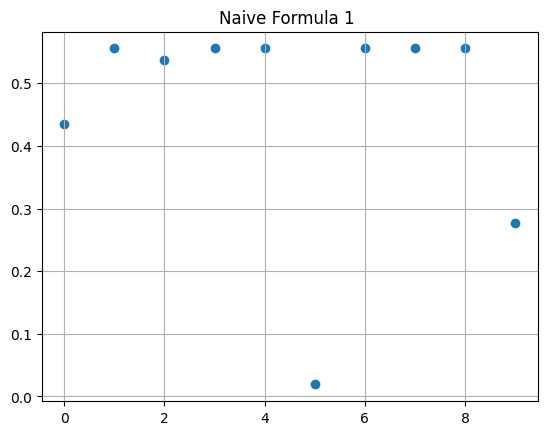

In [ ]:
plt.title("Naive Formula 1 ")
plt.scatter(ll.arange(0,10).tensor,naive1_attention.sum(-1).tensor[0])
plt.grid(True)
plt.show()

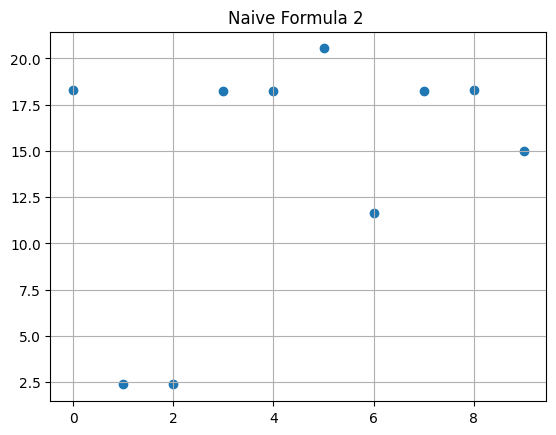

In [ ]:
plt.title("Naive Formula 2 ")
plt.scatter(ll.arange(0,10).tensor,naive2_attention.sum(-1).tensor[0])
plt.grid(True)
plt.show()

In [ ]:
mask =( 1 - ll.tril(ll.ones((1,10,10))) ) * -1e9
mask

Tensor(shape=(1, 10, 10), dtype=<class 'jax.numpy.float32'>, device=cpu, requires_grad=False)
[[[-0.e+00 -1.e+09 -1.e+09 -1.e+09 -1.e+09 -1.e+09 -1.e+09 -1.e+09
   -1.e+09 -1.e+09]
  [-0.e+00 -0.e+00 -1.e+09 -1.e+09 -1.e+09 -1.e+09 -1.e+09 -1.e+09
   -1.e+09 -1.e+09]
  [-0.e+00 -0.e+00 -0.e+00 -1.e+09 -1.e+09 -1.e+09 -1.e+09 -1.e+09
   -1.e+09 -1.e+09]
  [-0.e+00 -0.e+00 -0.e+00 -0.e+00 -1.e+09 -1.e+09 -1.e+09 -1.e+09
   -1.e+09 -1.e+09]
  [-0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00 -1.e+09 -1.e+09 -1.e+09
   -1.e+09 -1.e+09]
  [-0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00 -1.e+09 -1.e+09
   -1.e+09 -1.e+09]
  [-0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00 -1.e+09
   -1.e+09 -1.e+09]
  [-0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00
   -1.e+09 -1.e+09]
  [-0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00
   -0.e+00 -1.e+09]
  [-0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00
   -0.e+00 -0.e+00]]]

In [ ]:
naive1_attention = lma_naive1(logits,logits,logits,mask)
naive2_attention = lma_naive2(logits,logits,logits,mask)

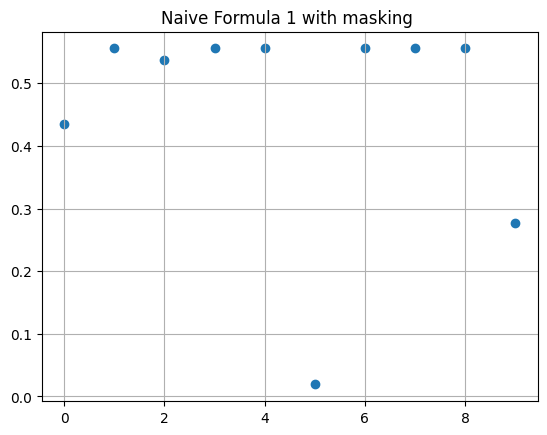

In [ ]:
plt.title("Naive Formula 1 with masking ")
plt.scatter(ll.arange(0,10).tensor,naive1_attention.sum(-1).tensor[0])
plt.grid(True)
plt.show()

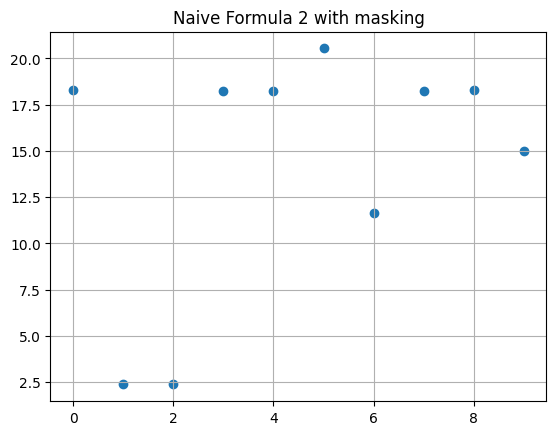

In [ ]:
plt.title("Naive Formula 2 with masking")
plt.scatter(ll.arange(0,10).tensor,naive2_attention.sum(-1).tensor[0])
plt.grid(True)
plt.show()

In [ ]:
def LMA_Naive_Formula1 (Q,K,V,mask = None) :
  interaction = {}
  std = math.sqrt(2/(32 * 2))
  fake_wg = ll.normal(0,std,(Q.shape[-1],Q.shape[-1]),max_random_seed=100)
  fake_wv = ll.normal(0,std,(Q.shape[-1],Q.shape[-1]),max_random_seed=100)
  fake_wp = ll.normal(0,std,(Q.shape[-1],Q.shape[-1]),max_random_seed=100)
  interaction['Query '] = Q.tensor
  lm = Q + K + V
  interaction[' Q + K + V'] = lm.tensor

  lm = ll.matmul(lm,fake_wg)
  interaction[' Q + K + V projected by Wg'] = lm.tensor
  v = ll.matmul(V,fake_wv)
  interaction['V projected'] = v.tensor
  score = ll.matmul(lm,K,transpose_b=True) / K.shape[-1] ** 0.5
  interaction['score'] = score.tensor
  if mask is not None :
    score + mask
  score = dl.activations.softmax(score,axis=-1,keepdims=True,use_crossentropy=False)
  interaction['softmax'] = score.tensor
  attn = ll.matmul(score,v)
  interaction['attn'] = attn.tensor
  attn = ll.matmul(attn,fake_wp)
  interaction['attn projected by Wo'] = attn.tensor
  return attn,interaction

In [ ]:
def LMA_Naive_Formula2 (Q,K,V,mask = None) :
  interaction = {}
  std = math.sqrt(2/(32 * 2))
  fake_wg = ll.normal(0,std,(Q.shape[-1],Q.shape[-1]),max_random_seed=100)
  fake_wp = ll.normal(0,std,(Q.shape[-1],Q.shape[-1]),max_random_seed=100)
  interaction['Query '] = Q.tensor
  lm = Q + K + V
  interaction[' Q + K + V'] = lm.tensor

  lm = ll.matmul(lm,fake_wg)
  interaction[' Q + K + V projected by Wg'] = lm.tensor
  score = ll.matmul(lm,K,transpose_b=True) / K.shape[-1] ** 0.5

  interaction['score'] = score.tensor
  if mask is not None :
    score + mask
  score = dl.activations.softmax(score,axis=-1,keepdims=True,use_crossentropy=False)
  interaction['softmax'] = score.tensor
  attn = ll.matmul(score,V)
  interaction['attn'] = attn.tensor
  attn = ll.matmul(attn,fake_wp)
  interaction['attn projected by Wo'] = attn.tensor
  return attn,interaction

In [ ]:
logits = ll.rand(1,1,32)


In [ ]:
attn1,interaction1 = LMA_Naive_Formula1(logits,logits,logits)

In [ ]:
interaction1

{'Query ': Array([[[0.7750319 , 0.12969995, 0.50448406, 0.93532336, 0.5162085 ,
          0.10637891, 0.8033351 , 0.52330935, 0.6086279 , 0.33789134,
          0.03172994, 0.4260218 , 0.3243991 , 0.7482946 , 0.17267466,
          0.29412425, 0.21364856, 0.09211504, 0.86676574, 0.55315673,
          0.31047404, 0.29173052, 0.8511733 , 0.4314394 , 0.55347717,
          0.26415277, 0.74931526, 0.2599002 , 0.22663343, 0.2785946 ,
          0.6807071 , 0.03695631]]], dtype=float32),
 ' Q + K + V': Array([[[2.3250957 , 0.38909984, 1.5134522 , 2.8059702 , 1.5486256 ,
          0.31913674, 2.410005  , 1.569928  , 1.8258837 , 1.013674  ,
          0.09518981, 1.2780654 , 0.97319734, 2.2448838 , 0.51802397,
          0.88237274, 0.6409457 , 0.27634513, 2.6002972 , 1.6594702 ,
          0.9314221 , 0.87519157, 2.5535197 , 1.2943182 , 1.6604315 ,
          0.7924583 , 2.2479458 , 0.77970064, 0.6799003 , 0.83578384,
          2.0421214 , 0.11086893]]], dtype=float32),
 ' Q + K + V projected by Wg':

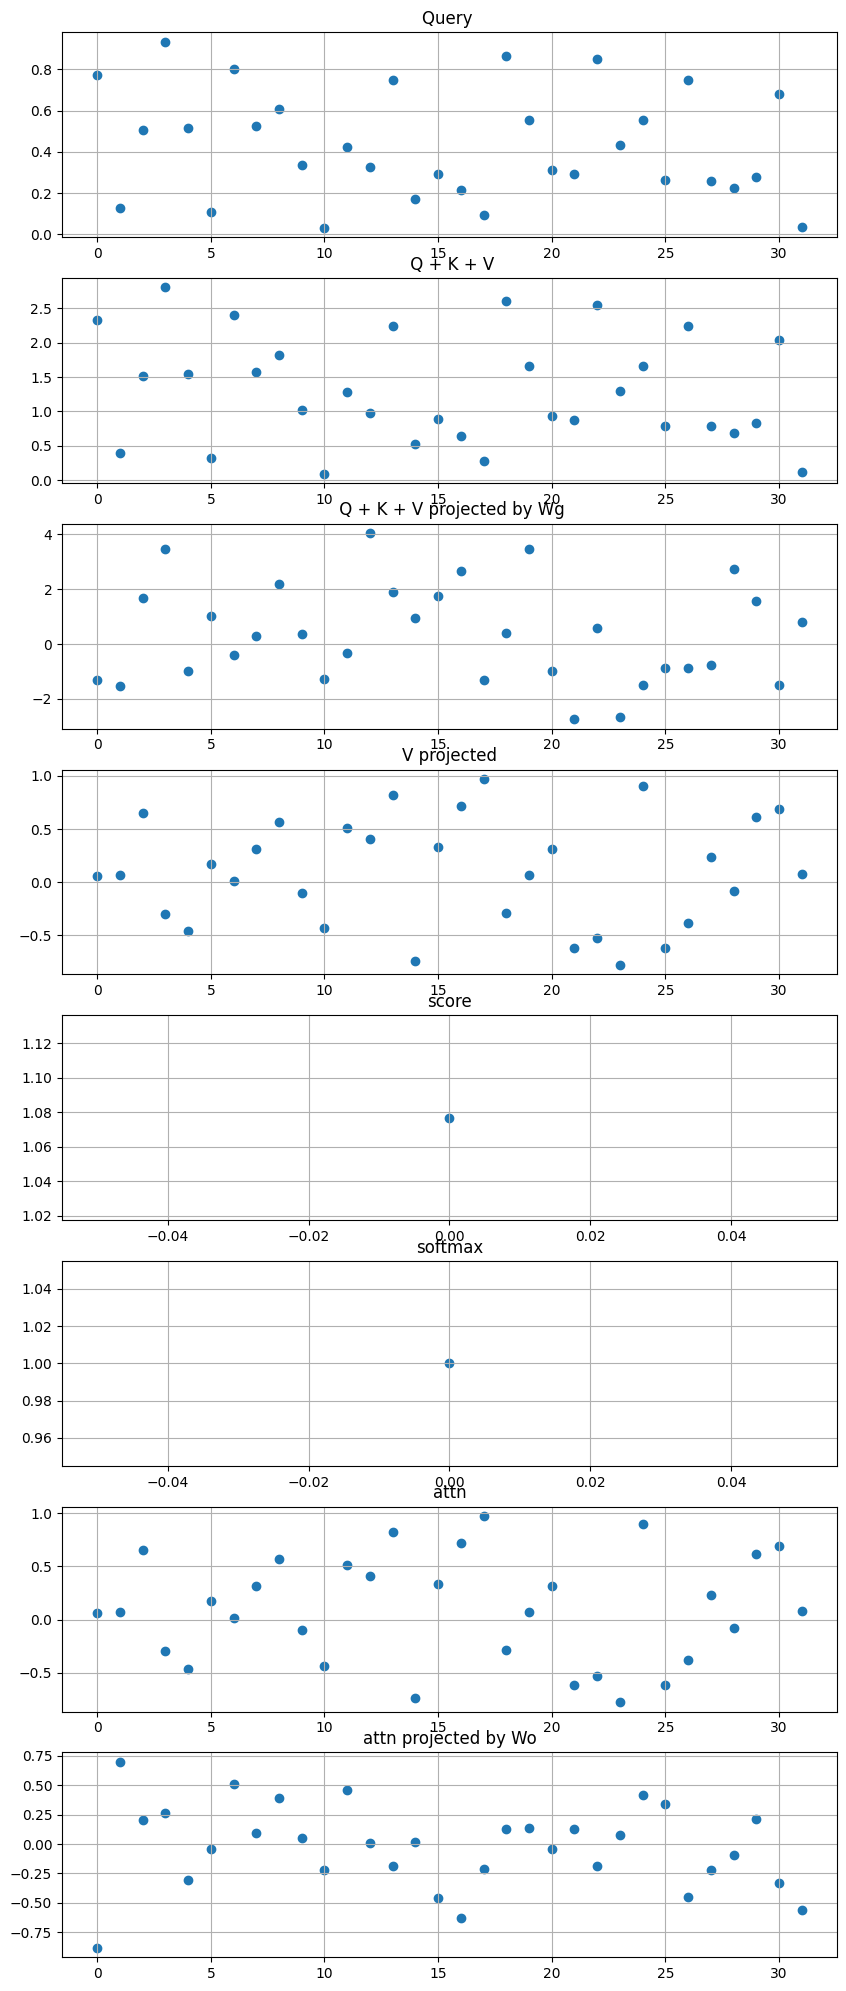

In [ ]:
fig,axes= plt.subplots(len(interaction1),1,figsize=(10,25))
name = list(interaction1.keys())
for i in range(len(name)) :
  axes[i].scatter(ll.arange(0,interaction1[name[i]].shape[-1]).tensor,interaction1[name[i]][0])
  axes[i].set_title(name[i])
  axes[i].grid(True)
plt.show()

In [ ]:
attn1.tensor[-1].shape

(1, 32)

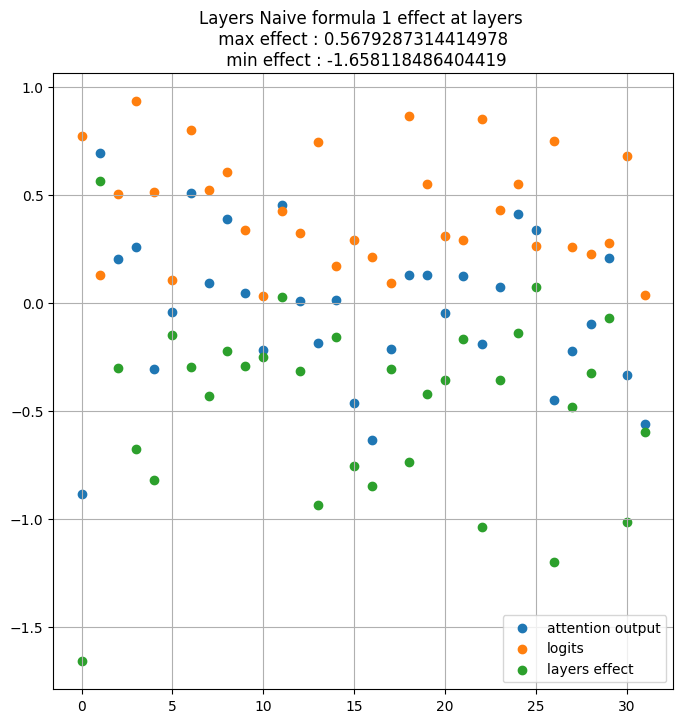

In [ ]:
effect = attn1.tensor[-1] - logits.tensor[-1]
fig = plt.figure(figsize=(8,8))
plt.title(f"Layers Naive formula 1 effect at layers \n max effect : {ll.max(effect).tensor} \n min effect : {ll.min(effect).tensor}")
plt.scatter(ll.arange(0,32).tensor,attn1.tensor[-1],label='attention output')
plt.scatter(ll.arange(0,32).tensor,logits.tensor[-1],label='logits')
plt.scatter(ll.arange(0,32).tensor, attn1.tensor[-1] - logits.tensor[-1] ,label='layers effect')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
attn2,interaction2 = LMA_Naive_Formula2(logits,logits,logits)

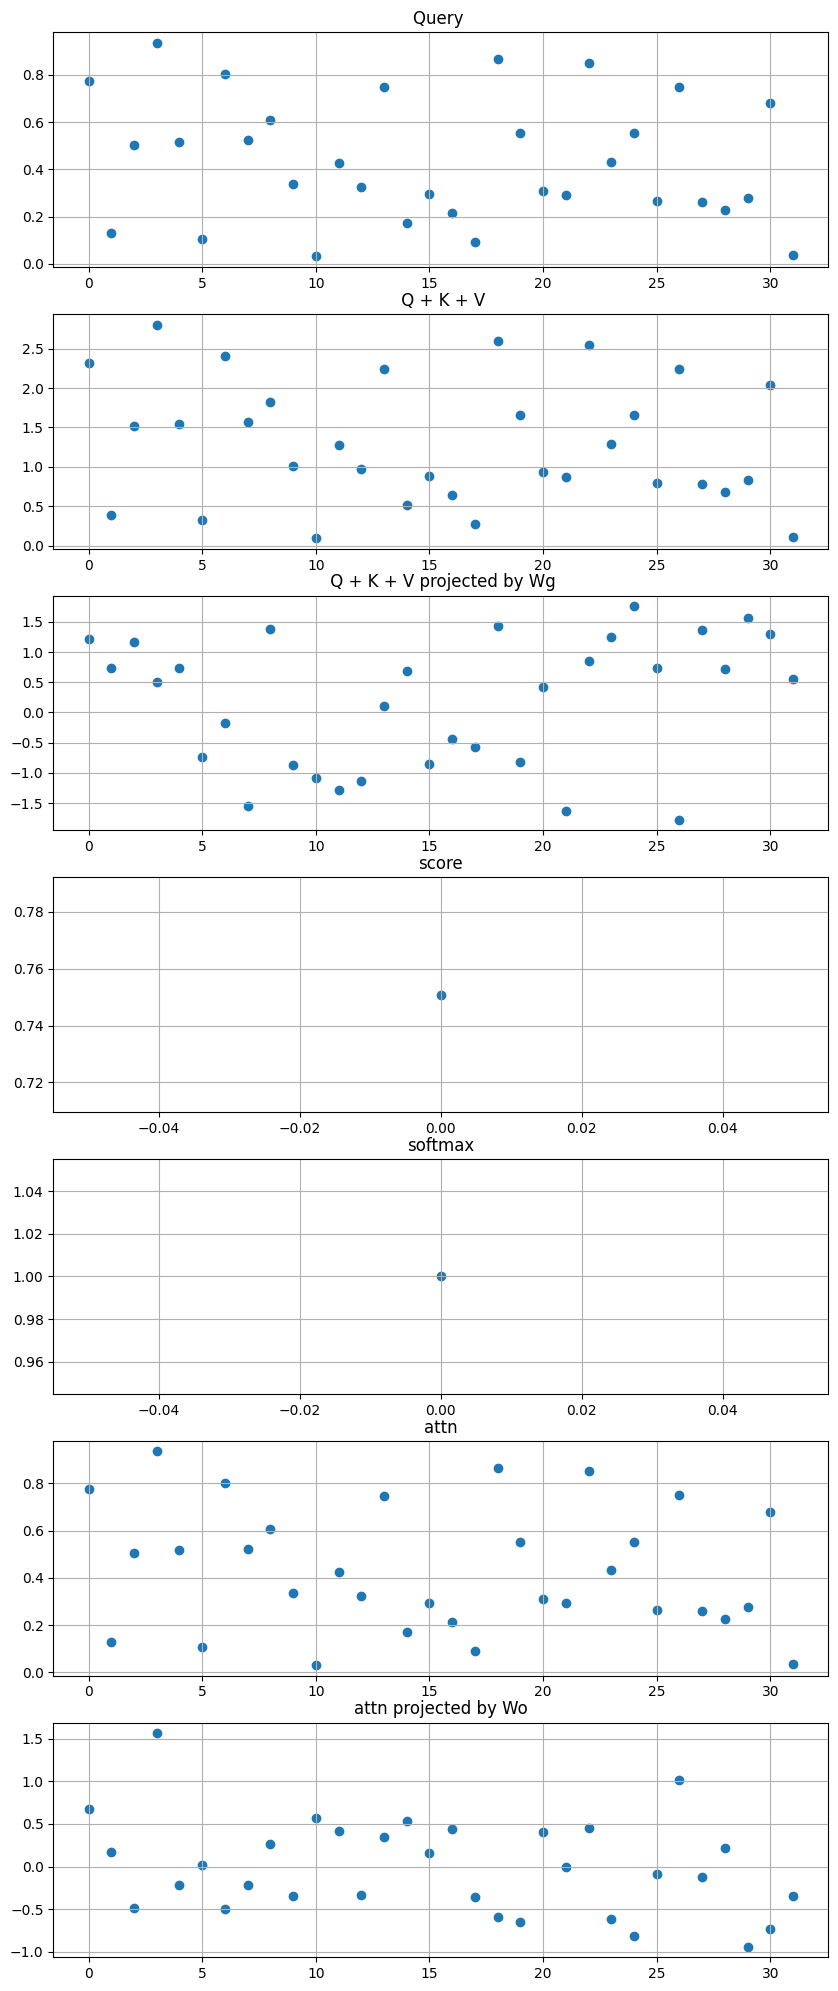

In [ ]:
fig,axes= plt.subplots(len(interaction2),1,figsize=(10,25))
name = list(interaction2.keys())
for i in range(len(name)) :
  axes[i].scatter(ll.arange(0,interaction2[name[i]].shape[-1]).tensor,interaction2[name[i]][0])
  axes[i].set_title(name[i])
  axes[i].grid(True)
plt.show()

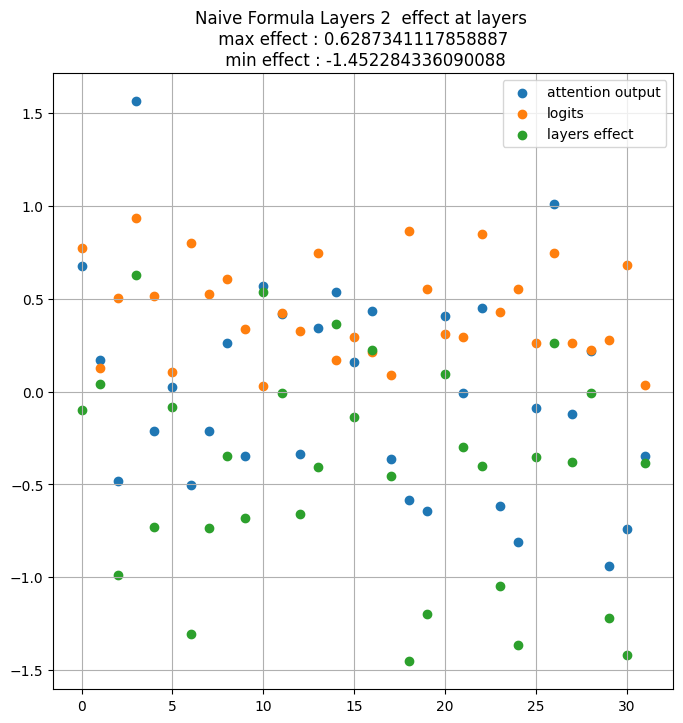

In [ ]:
effect = attn2.tensor[-1] - logits.tensor[-1]
fig = plt.figure(figsize=(8,8))
plt.title(f"Naive Formula Layers 2  effect at layers \n max effect : {ll.max(effect).tensor} \n min effect : {ll.min(effect).tensor}")
plt.scatter(ll.arange(0,32).tensor,attn2.tensor[-1],label='attention output')
plt.scatter(ll.arange(0,32).tensor,logits.tensor[-1],label='logits')
plt.scatter(ll.arange(0,32).tensor, attn2.tensor[-1] - logits.tensor[-1] ,label='layers effect')
plt.legend()
plt.grid(True)
plt.show()

# research at Architecture Level before diving to entropy, str , var , kurtosis curve. jacobian sensitivity at logits output.

In [ ]:
class BlockTransformersLMA1 (ln.Component) :
  def __init__ (self,embed_dim,drop_rate) :
    super().__init__()
    self.attention = Classic_LMA_Naiveformula(embed_dim=embed_dim)
    self.dropout = ln.Dropout(drop_rate)
    self.ffn = ln.FeedForwardNetwork(embed_dim=embed_dim,ffn_dim=embed_dim * 4)
    self.dropout2 =  ln.Dropout(drop_rate)
    self.layernorm1 = ln.RMSNorm(embed_dim)
    self.layernorm2 = ln.RMSNorm(embed_dim)

  def forwardpass(self,x) :
    _,s,_ = x.shape
    mask = (1 - ll.tril(ll.ones((s,s)),diagonal=0,device=x.device)) * -1e9
    norm = self.layernorm1(x)
    attn = self.attention(norm,norm,norm,mask)
    attn = self.dropout(attn)
    x = x + attn

    z = self.layernorm2(x)
    z = self.ffn(z)
    z = self.dropout2(z)
    x = x + z
    return x

class TransformersLMA1 (ln.Component) :
  def __init__ (self,vocab_size,embed_dim,num_layers,max_pos) :
    super().__init__()
    self.embedding = ln.Embedding(vocab_size,embedding_dim=embed_dim)
    self.poslearn = ln.Embedding(max_pos,embedding_dim=embed_dim)
    self.scale = embed_dim **0.5
    self.block = ln.Sequential([
        BlockTransformersLMA1(embed_dim,0.1) for _ in range(num_layers)
    ])
    self.fc = ln.Linear(embed_dim,vocab_size)

  def forwardpass(self,x) :
    _,s, = x.shape
    x = self.embedding(x)
    x = x * self.scale
    pos = ll.arange(0,s,device=x.device)
    pos = self.poslearn(pos)
    pos = ll.expand_dims(pos,axis=0)

    x = x + pos
    x = self.block(x)
    x = self.fc(x)
    return x


In [ ]:
SubjectModel1 = TransformersLMA1(tokenizer.len_vocab + 1,128,num_layers=4,max_pos=1000)
SubjectModel1.to("gpu")
SubjectModel1.train(True)

TransformersLMA1 to gpu
name : TransformersLMA1 status : active || requires_grad : True


In [ ]:
optim = dl.optimizers.AdamW(SubjectModel1.parameter(),lr=0.0001,clip_norm=1.0)
loss_fn = dl.loss.SparseCrossentropy()
from tqdm import tqdm
loss_record = []

In [ ]:
dataload = ll.preprocessing.DataLoader(Dataset(),64)

In [ ]:
epochs = 40
for epoch in range(epochs) :
  loss_total = 0
  iterator = tqdm(dataload)
  for x,y in iterator :
    y_pred = SubjectModel1(x)
    loss = loss_fn(y,y_pred)
    loss.backwardpass()
    optim.step()
    loss.reset_grad()
    iterator.set_description(f"epoch {epoch + 1} / {epochs}")
    iterator.set_postfix(loss = loss.tensor)
    loss_total = loss_total + loss.tensor
  loss_total = loss_total / len(dataload)
  loss_record.append(loss_total)
  print(f"average loss : {loss_total}")

epoch 1 / 40: 100%|██████████| 85/85 [01:56<00:00,  1.37s/it, loss=0.91916513]


average loss : 4.188684940338135


epoch 2 / 40: 100%|██████████| 85/85 [01:19<00:00,  1.07it/s, loss=0.7588715]


average loss : 0.9007328152656555


epoch 3 / 40: 100%|██████████| 85/85 [01:18<00:00,  1.08it/s, loss=0.71696323]


average loss : 0.8209432363510132


epoch 4 / 40: 100%|██████████| 85/85 [01:18<00:00,  1.08it/s, loss=0.69362825]


average loss : 0.7921413779258728


epoch 5 / 40: 100%|██████████| 85/85 [01:17<00:00,  1.10it/s, loss=0.6773106]


average loss : 0.7733752131462097


epoch 6 / 40: 100%|██████████| 85/85 [01:16<00:00,  1.11it/s, loss=0.6625838]


average loss : 0.7589616775512695


epoch 7 / 40: 100%|██████████| 85/85 [01:16<00:00,  1.11it/s, loss=0.649584]


average loss : 0.7470237612724304


epoch 8 / 40: 100%|██████████| 85/85 [01:17<00:00,  1.10it/s, loss=0.63855845]


average loss : 0.7363364696502686


epoch 9 / 40: 100%|██████████| 85/85 [01:15<00:00,  1.12it/s, loss=0.6282964]


average loss : 0.7269392013549805


epoch 10 / 40: 100%|██████████| 85/85 [01:17<00:00,  1.10it/s, loss=0.6162921]


average loss : 0.7184057831764221


epoch 11 / 40: 100%|██████████| 85/85 [01:16<00:00,  1.11it/s, loss=0.60856974]


average loss : 0.710350751876831


epoch 12 / 40: 100%|██████████| 85/85 [01:15<00:00,  1.12it/s, loss=0.5999357]


average loss : 0.7030702829360962


epoch 13 / 40: 100%|██████████| 85/85 [01:15<00:00,  1.12it/s, loss=0.592582]


average loss : 0.6962194442749023


epoch 14 / 40: 100%|██████████| 85/85 [01:15<00:00,  1.12it/s, loss=0.583153]


average loss : 0.6896447539329529


epoch 15 / 40: 100%|██████████| 85/85 [01:15<00:00,  1.13it/s, loss=0.57610375]


average loss : 0.683559000492096


epoch 16 / 40: 100%|██████████| 85/85 [01:15<00:00,  1.12it/s, loss=0.5697969]


average loss : 0.6778759956359863


epoch 17 / 40: 100%|██████████| 85/85 [01:15<00:00,  1.13it/s, loss=0.561902]


average loss : 0.6725620031356812


epoch 18 / 40: 100%|██████████| 85/85 [01:16<00:00,  1.11it/s, loss=0.55694413]


average loss : 0.6674242615699768


epoch 19 / 40: 100%|██████████| 85/85 [01:16<00:00,  1.12it/s, loss=0.5477605]


average loss : 0.6623615026473999


epoch 20 / 40: 100%|██████████| 85/85 [01:16<00:00,  1.11it/s, loss=0.54377943]


average loss : 0.657690703868866


epoch 21 / 40: 100%|██████████| 85/85 [01:16<00:00,  1.11it/s, loss=0.53778714]


average loss : 0.6534287929534912


epoch 22 / 40: 100%|██████████| 85/85 [01:15<00:00,  1.12it/s, loss=0.53371465]


average loss : 0.6492019295692444


epoch 23 / 40: 100%|██████████| 85/85 [01:16<00:00,  1.12it/s, loss=0.5266205]


average loss : 0.6453021764755249


epoch 24 / 40: 100%|██████████| 85/85 [01:16<00:00,  1.11it/s, loss=0.5221895]


average loss : 0.641464352607727


epoch 25 / 40: 100%|██████████| 85/85 [01:15<00:00,  1.12it/s, loss=0.5182278]


average loss : 0.6378026008605957


epoch 26 / 40: 100%|██████████| 85/85 [01:15<00:00,  1.12it/s, loss=0.5112703]


average loss : 0.6342620253562927


epoch 27 / 40: 100%|██████████| 85/85 [01:15<00:00,  1.12it/s, loss=0.5090105]


average loss : 0.6308300495147705


epoch 28 / 40: 100%|██████████| 85/85 [01:15<00:00,  1.12it/s, loss=0.5041923]


average loss : 0.6275516748428345


epoch 29 / 40: 100%|██████████| 85/85 [01:16<00:00,  1.12it/s, loss=0.49771324]


average loss : 0.6243035197257996


epoch 30 / 40: 100%|██████████| 85/85 [01:15<00:00,  1.13it/s, loss=0.49658567]


average loss : 0.6214107275009155


epoch 31 / 40: 100%|██████████| 85/85 [01:16<00:00,  1.12it/s, loss=0.49109757]


average loss : 0.6185643672943115


epoch 32 / 40: 100%|██████████| 85/85 [01:15<00:00,  1.12it/s, loss=0.4867316]


average loss : 0.6158435344696045


epoch 33 / 40: 100%|██████████| 85/85 [01:16<00:00,  1.11it/s, loss=0.48338586]


average loss : 0.6129364371299744


epoch 34 / 40: 100%|██████████| 85/85 [01:15<00:00,  1.12it/s, loss=0.48027268]


average loss : 0.6103823184967041


epoch 35 / 40: 100%|██████████| 85/85 [01:15<00:00,  1.13it/s, loss=0.4793512]


average loss : 0.6078407168388367


epoch 36 / 40: 100%|██████████| 85/85 [01:15<00:00,  1.12it/s, loss=0.47486296]


average loss : 0.6054444909095764


epoch 37 / 40: 100%|██████████| 85/85 [01:15<00:00,  1.13it/s, loss=0.4709748]


average loss : 0.6029834151268005


epoch 38 / 40: 100%|██████████| 85/85 [01:15<00:00,  1.12it/s, loss=0.46787333]


average loss : 0.6008889079093933


epoch 39 / 40: 100%|██████████| 85/85 [01:14<00:00,  1.13it/s, loss=0.46542433]


average loss : 0.5985119938850403


epoch 40 / 40: 100%|██████████| 85/85 [01:14<00:00,  1.14it/s, loss=0.46352246]

average loss : 0.5964536666870117


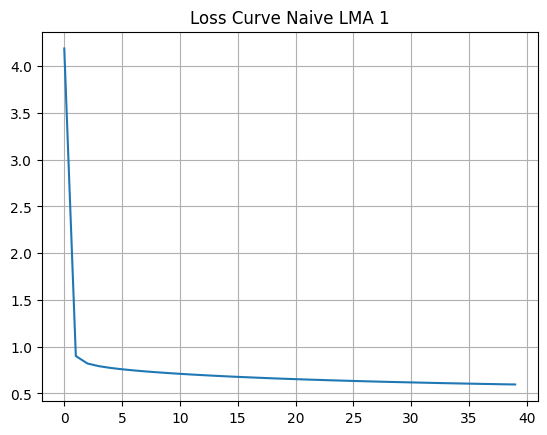

In [ ]:
plt.title("Loss Curve Naive LMA 1")
plt.plot(loss_record)
plt.grid(True)
plt.show()

In [ ]:
class BlockTransformersLMA2 (ln.Component) :
  def __init__ (self,embed_dim,drop_rate) :
    super().__init__()
    self.attention = LMA_naiveFormula2(embed_dim=embed_dim)
    self.dropout = ln.Dropout(drop_rate)
    self.ffn = ln.FeedForwardNetwork(embed_dim=embed_dim,ffn_dim=embed_dim * 4)
    self.dropout2 =  ln.Dropout(drop_rate)
    self.layernorm1 = ln.RMSNorm(embed_dim)
    self.layernorm2 = ln.RMSNorm(embed_dim)

  def forwardpass(self,x) :
    _,s,_ = x.shape
    mask = (1 - ll.tril(ll.ones((s,s)),diagonal=0,device=x.device)) * -1e9
    norm = self.layernorm1(x)
    attn = self.attention(norm,norm,norm,mask)
    attn = self.dropout(attn)
    x = x + attn

    z = self.layernorm2(x)
    z = self.ffn(z)
    z = self.dropout2(z)
    x = x + z
    return x

class TransformersLMA2 (ln.Component) :
  def __init__ (self,vocab_size,embed_dim,num_layers,max_pos) :
    super().__init__()
    self.embedding = ln.Embedding(vocab_size,embedding_dim=embed_dim)
    self.poslearn = ln.Embedding(max_pos,embedding_dim=embed_dim)
    self.scale = embed_dim **0.5
    self.block = ln.Sequential([
        BlockTransformersLMA2(embed_dim,0.1) for _ in range(num_layers)
    ])
    self.fc = ln.Linear(embed_dim,vocab_size)

  def forwardpass(self,x) :
    _,s, = x.shape
    x = self.embedding(x)
    x = x * self.scale
    pos = ll.arange(0,s,device=x.device)
    pos = self.poslearn(pos)
    pos = ll.expand_dims(pos,axis=0)

    x = x + pos
    x = self.block(x)
    x = self.fc(x)
    return x


In [ ]:
subject_model2 = TransformersLMA2(tokenizer.len_vocab + 1,128,num_layers=4,max_pos=1000)
subject_model2.to("gpu")
subject_model2.train(True)

TransformersLMA2 to gpu
name : TransformersLMA2 status : active || requires_grad : True


In [ ]:
optim = dl.optimizers.AdamW(subject_model2.parameter(),lr=0.0001,clip_norm=1.0)
loss_fn = dl.loss.SparseCrossentropy()
from tqdm import tqdm
loss_record = []

In [ ]:
dataload = ll.preprocessing.DataLoader(Dataset(),64)

In [ ]:
epochs = 40
for epoch in range(epochs) :
  loss_total = 0
  iterator = tqdm(dataload)
  for x,y in iterator :
    y_pred = subject_model2(x)
    loss = loss_fn(y,y_pred)
    loss.backwardpass()
    optim.step()
    loss.reset_grad()
    iterator.set_description(f"epoch {epoch + 1} / {epochs}")
    iterator.set_postfix(loss = loss.tensor)
    loss_total = loss_total + loss.tensor
  loss_total = loss_total / len(dataload)
  loss_record.append(loss_total)
  print(f"average loss : {loss_total}")


epoch 1 / 40: 100%|██████████| 85/85 [01:43<00:00,  1.21s/it, loss=1.0775629]


average loss : 5.641058921813965


epoch 2 / 40: 100%|██████████| 85/85 [01:20<00:00,  1.05it/s, loss=0.76612467]


average loss : 0.9056609272956848


epoch 3 / 40: 100%|██████████| 85/85 [01:20<00:00,  1.05it/s, loss=0.7203729]


average loss : 0.8147479891777039


epoch 4 / 40: 100%|██████████| 85/85 [01:20<00:00,  1.06it/s, loss=0.6947204]


average loss : 0.7854285836219788


epoch 5 / 40: 100%|██████████| 85/85 [01:20<00:00,  1.06it/s, loss=0.6769266]


average loss : 0.7666402459144592


epoch 6 / 40: 100%|██████████| 85/85 [01:20<00:00,  1.06it/s, loss=0.6596929]


average loss : 0.7519081830978394


epoch 7 / 40: 100%|██████████| 85/85 [01:20<00:00,  1.05it/s, loss=0.6458214]


average loss : 0.7396539449691772


epoch 8 / 40: 100%|██████████| 85/85 [01:20<00:00,  1.06it/s, loss=0.63435507]


average loss : 0.7289952635765076


epoch 9 / 40: 100%|██████████| 85/85 [01:19<00:00,  1.07it/s, loss=0.6237153]


average loss : 0.719261884689331


epoch 10 / 40: 100%|██████████| 85/85 [01:19<00:00,  1.06it/s, loss=0.6139379]


average loss : 0.7107590436935425


epoch 11 / 40: 100%|██████████| 85/85 [01:19<00:00,  1.07it/s, loss=0.6046118]


average loss : 0.7026659846305847


epoch 12 / 40: 100%|██████████| 85/85 [01:20<00:00,  1.06it/s, loss=0.5963285]


average loss : 0.6952555775642395


epoch 13 / 40: 100%|██████████| 85/85 [01:19<00:00,  1.07it/s, loss=0.5855665]


average loss : 0.6881338953971863


epoch 14 / 40: 100%|██████████| 85/85 [01:20<00:00,  1.06it/s, loss=0.57898456]


average loss : 0.6817965507507324


epoch 15 / 40: 100%|██████████| 85/85 [01:19<00:00,  1.07it/s, loss=0.57246935]


average loss : 0.6758108139038086


epoch 16 / 40: 100%|██████████| 85/85 [01:19<00:00,  1.06it/s, loss=0.5661102]


average loss : 0.6700526475906372


epoch 17 / 40: 100%|██████████| 85/85 [01:19<00:00,  1.08it/s, loss=0.5576293]


average loss : 0.6647265553474426


epoch 18 / 40: 100%|██████████| 85/85 [01:19<00:00,  1.07it/s, loss=0.54990387]


average loss : 0.6596521139144897


epoch 19 / 40: 100%|██████████| 85/85 [01:18<00:00,  1.08it/s, loss=0.5425757]


average loss : 0.6548194289207458


epoch 20 / 40: 100%|██████████| 85/85 [01:18<00:00,  1.08it/s, loss=0.53841645]


average loss : 0.6501173973083496


epoch 21 / 40: 100%|██████████| 85/85 [01:18<00:00,  1.09it/s, loss=0.5304603]


average loss : 0.6459270119667053


epoch 22 / 40: 100%|██████████| 85/85 [01:19<00:00,  1.07it/s, loss=0.5271609]


average loss : 0.641650915145874


epoch 23 / 40: 100%|██████████| 85/85 [01:18<00:00,  1.08it/s, loss=0.52195776]


average loss : 0.6376422047615051


epoch 24 / 40: 100%|██████████| 85/85 [01:19<00:00,  1.07it/s, loss=0.5176349]


average loss : 0.634090781211853


epoch 25 / 40: 100%|██████████| 85/85 [01:18<00:00,  1.09it/s, loss=0.51077497]


average loss : 0.630187451839447


epoch 26 / 40: 100%|██████████| 85/85 [01:18<00:00,  1.08it/s, loss=0.5070181]


average loss : 0.6268283128738403


epoch 27 / 40: 100%|██████████| 85/85 [01:18<00:00,  1.08it/s, loss=0.5015515]


average loss : 0.6234102249145508


epoch 28 / 40: 100%|██████████| 85/85 [01:18<00:00,  1.08it/s, loss=0.49837282]


average loss : 0.6202908158302307


epoch 29 / 40: 100%|██████████| 85/85 [01:18<00:00,  1.08it/s, loss=0.4934271]


average loss : 0.6171373128890991


epoch 30 / 40: 100%|██████████| 85/85 [01:18<00:00,  1.08it/s, loss=0.49233636]


average loss : 0.614331841468811


epoch 31 / 40: 100%|██████████| 85/85 [01:18<00:00,  1.08it/s, loss=0.4875013]


average loss : 0.6115404367446899


epoch 32 / 40: 100%|██████████| 85/85 [01:18<00:00,  1.08it/s, loss=0.48275295]


average loss : 0.6087085604667664


epoch 33 / 40: 100%|██████████| 85/85 [01:19<00:00,  1.08it/s, loss=0.47761697]


average loss : 0.6060597896575928


epoch 34 / 40: 100%|██████████| 85/85 [01:18<00:00,  1.09it/s, loss=0.47414532]


average loss : 0.603486180305481


epoch 35 / 40: 100%|██████████| 85/85 [01:17<00:00,  1.09it/s, loss=0.47215232]


average loss : 0.6010874509811401


epoch 36 / 40: 100%|██████████| 85/85 [01:18<00:00,  1.09it/s, loss=0.46781427]


average loss : 0.5986348986625671


epoch 37 / 40: 100%|██████████| 85/85 [01:17<00:00,  1.10it/s, loss=0.4667486]


average loss : 0.596350371837616


epoch 38 / 40: 100%|██████████| 85/85 [01:18<00:00,  1.08it/s, loss=0.460923]


average loss : 0.5941094160079956


epoch 39 / 40: 100%|██████████| 85/85 [01:16<00:00,  1.10it/s, loss=0.4581396]


average loss : 0.5917964577674866


epoch 40 / 40: 100%|██████████| 85/85 [01:16<00:00,  1.11it/s, loss=0.456029]

average loss : 0.5897054076194763


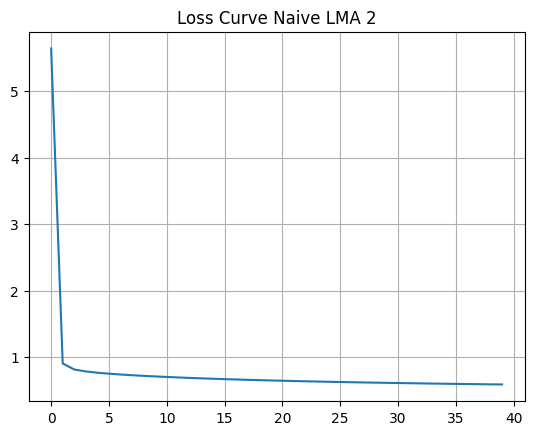

In [ ]:
plt.title("Loss Curve Naive LMA 2")
plt.plot(loss_record)
plt.grid(True)
plt.show()

In [ ]:
from typing import Literal
class NaiveLMA3 (ln.Component) :
  def __init__ (self,embed_dim,residural_mode : Literal['rezero','layerscale'] ) :
    super().__init__()
    std = math.sqrt(2 / (embed_dim * 2))
    self.wg =ln.Parameter(
        tensor = ll.normal(0,std,(embed_dim,embed_dim),max_random_seed=100)
    )
    self.wo = ln.Parameter(
        tensor = ll.normal(0,std,(embed_dim,embed_dim),max_random_seed=100)
    )
    if residural_mode =='rezero' :
      self.factor = ln.Parameter(
          tensor = ll.zeros((1,1,embed_dim))
      )
    else :
      self.factor = ln.Parameter(
          tensor = ll.ones((1,1,embed_dim)) * 1e-5
      )

  def forwardpass(self,Q,K,V,mask = None) :
    scale_factor = self.factor * (K + V)
    lm = ll.matmul(Q + scale_factor,self.wg)
    score = ll.matmul(lm,K,transpose_b=True) / K.shape[-1] ** 0.5
    if mask is not None :
      score = score + mask

    score = dl.activations.softmax(score,axis=-1,keepdims=True,use_crossentropy=False)
    attn = ll.matmul(score,V)
    attn = ll.matmul(attn,self.wo)
    return attn


class NaiveLMA4 (ln.Component) :
  def __init__ (self,embed_dim,residural_mode : Literal['sigmoid','relu','swish'] ) :
    super().__init__()
    std = math.sqrt(2 / (embed_dim * 2))
    self.wg =ln.Parameter(
        tensor = ll.normal(0,std,(embed_dim,embed_dim),max_random_seed=100)
    )
    self.wo = ln.Parameter(
        tensor = ll.normal(0,std,(embed_dim,embed_dim),max_random_seed=100)
    )
    self.factor = ln.Parameter(
        tensor = ll.normal(0,std,(1,1,embed_dim))
    )
    self.activ = residural_mode

  def forwardpass(self,Q,K,V,mask = None) :
    scale_factor = self.factor * (K + V)
    if self.activ == 'sigmoid' :
      scale_factor = dl.activations.sigmoid(scale_factor)
    elif self.activ == 'relu' :
      scale_factor = dl.activations.relu(scale_factor)
    else :
      scale_factor = dl.activations.swish(scale_factor)

    lm = ll.matmul(Q + scale_factor,self.wg)
    score = ll.matmul(lm,K,transpose_b=True) / K.shape[-1] ** 0.5
    if mask is not None :
      score = score + mask

    score = dl.activations.softmax(score,axis=-1,keepdims=True,use_crossentropy=False)
    attn = ll.matmul(score,V)
    attn = ll.matmul(attn,self.wo)
    return attn


In [ ]:
class BlockTransformers3 (ln.Component) :
  def __init__ (self,embed_dim,drop_rate,residural_mode) :
    super().__init__()
    self.attention = NaiveLMA3(embed_dim=embed_dim,residural_mode=residural_mode)
    self.dropout = ln.Dropout(drop_rate)
    self.ffn = ln.FeedForwardNetwork(embed_dim=embed_dim,ffn_dim=embed_dim * 4)
    self.dropout2 =  ln.Dropout(drop_rate)
    self.rmsnorm1 = ln.RMSNorm(embed_dim)
    self.rmsnorm2 = ln.RMSNorm(embed_dim)

  def forwardpass(self,x) :
    _,S,_ = x.shape
    mask = (1 - ll.tril(ll.ones((S,S)),diagonal=0,device=x.device)) * -1e9
    z = self.rmsnorm1(x)
    attn = self.attention(z,z,z,mask)
    attn = self.dropout(attn)
    x = x + attn

    z = self.rmsnorm2(x)
    ffn = self.ffn(z)
    ffn = self.dropout2(ffn)
    x = x + ffn
    return x

class NaiveLMATransformers3 (ln.Component) :
  def __init__(self,vocab_size,embed_dim,max_pos,num_layers,drop_rate,residural_mode) :
    super().__init__()
    self.embedding = ln.Embedding(vocab_size=vocab_size,embedding_dim=embed_dim)
    self.poslearn = ln.Embedding(max_pos,embedding_dim=embed_dim)
    self.scale = embed_dim ** 0.5
    self.block = ln.Sequential([
        BlockTransformers3(embed_dim,drop_rate,residural_mode) for _ in range(num_layers)
    ])
    self.fc = ln.Linear(embed_dim,vocab_size)

  def forwardpass(self,x) :
    _,s = x.shape
    x = self.embedding(x)
    x = x *  self.scale
    pos = ll.arange(0,s,device=x.device)
    pos = self.poslearn(pos)
    pos = ll.expand_dims(pos,axis=0)
    x = x + pos
    x = self.block(x)
    x = self.fc(x)
    return x

In [ ]:
dataload = ll.preprocessing.DataLoader(Dataset(),64)

In [ ]:
SubjectModel3_1 = NaiveLMATransformers3(
    vocab_size=tokenizer.len_vocab + 1,
    embed_dim=128,
    max_pos=1000,
    num_layers=4,
    drop_rate=0.1,residural_mode='rezero'
)
SubjectModel3_1.to("gpu")
SubjectModel3_1.train(True)
optim = dl.optimizers.AdamW(SubjectModel3_1.parameter(),lr=0.0001,clip_norm=1.0)
loss_fn = dl.loss.SparseCrossentropy()
from tqdm import tqdm
loss_record = []

NaiveLMATransformers3 to gpu
name : NaiveLMATransformers3 status : active || requires_grad : True


In [ ]:
epochs = 40
for epoch in range(epochs) :
  iterator = tqdm(dataload)
  loss_total = 0
  for x,y in iterator :
    y_pred = SubjectModel3_1(x)
    loss = loss_fn(y,y_pred)
    loss.backwardpass()
    optim.step()
    loss.reset_grad()
    iterator.set_description(f"epoch {epoch + 1} / {epochs}")
    iterator.set_postfix(loss = loss.tensor)
    loss_total = loss_total + loss.tensor
  loss_total = loss_total / len(dataload)
  loss_record.append(loss_total)
  print(f"average loss : {loss_total}")

epoch 1 / 40: 100%|██████████| 85/85 [01:43<00:00,  1.22s/it, loss=1.1308403]


average loss : 5.113685131072998


epoch 2 / 40: 100%|██████████| 85/85 [01:22<00:00,  1.03it/s, loss=0.7832912]


average loss : 0.95168536901474


epoch 3 / 40: 100%|██████████| 85/85 [01:22<00:00,  1.03it/s, loss=0.7274292]


average loss : 0.8249052166938782


epoch 4 / 40: 100%|██████████| 85/85 [01:22<00:00,  1.03it/s, loss=0.6996433]


average loss : 0.7898143529891968


epoch 5 / 40: 100%|██████████| 85/85 [01:21<00:00,  1.04it/s, loss=0.6805749]


average loss : 0.7695057988166809


epoch 6 / 40: 100%|██████████| 85/85 [01:22<00:00,  1.03it/s, loss=0.66560227]


average loss : 0.7541679739952087


epoch 7 / 40: 100%|██████████| 85/85 [01:21<00:00,  1.04it/s, loss=0.6519025]


average loss : 0.741669237613678


epoch 8 / 40: 100%|██████████| 85/85 [01:21<00:00,  1.04it/s, loss=0.64068156]


average loss : 0.7309275269508362


epoch 9 / 40: 100%|██████████| 85/85 [01:21<00:00,  1.05it/s, loss=0.6291965]


average loss : 0.7214043140411377


epoch 10 / 40: 100%|██████████| 85/85 [01:21<00:00,  1.04it/s, loss=0.61835164]


average loss : 0.712670624256134


epoch 11 / 40: 100%|██████████| 85/85 [01:21<00:00,  1.04it/s, loss=0.6088925]


average loss : 0.7047410607337952


epoch 12 / 40: 100%|██████████| 85/85 [01:21<00:00,  1.04it/s, loss=0.5999928]


average loss : 0.6975066661834717


epoch 13 / 40: 100%|██████████| 85/85 [01:22<00:00,  1.03it/s, loss=0.5925638]


average loss : 0.6906725764274597


epoch 14 / 40: 100%|██████████| 85/85 [01:22<00:00,  1.03it/s, loss=0.5859971]


average loss : 0.6845483779907227


epoch 15 / 40: 100%|██████████| 85/85 [01:22<00:00,  1.02it/s, loss=0.57812345]


average loss : 0.6785720586776733


epoch 16 / 40: 100%|██████████| 85/85 [01:21<00:00,  1.04it/s, loss=0.57179403]


average loss : 0.6730091571807861


epoch 17 / 40: 100%|██████████| 85/85 [01:22<00:00,  1.03it/s, loss=0.56406444]


average loss : 0.6677350997924805


epoch 18 / 40: 100%|██████████| 85/85 [01:21<00:00,  1.05it/s, loss=0.5612017]


average loss : 0.6628936529159546


epoch 19 / 40: 100%|██████████| 85/85 [01:20<00:00,  1.06it/s, loss=0.55454093]


average loss : 0.6581883430480957


epoch 20 / 40: 100%|██████████| 85/85 [01:21<00:00,  1.05it/s, loss=0.54574794]


average loss : 0.6534531712532043


epoch 21 / 40: 100%|██████████| 85/85 [01:21<00:00,  1.04it/s, loss=0.54273826]


average loss : 0.6493955254554749


epoch 22 / 40: 100%|██████████| 85/85 [01:20<00:00,  1.06it/s, loss=0.53542924]


average loss : 0.645311713218689


epoch 23 / 40: 100%|██████████| 85/85 [01:21<00:00,  1.04it/s, loss=0.5326996]


average loss : 0.6413842439651489


epoch 24 / 40: 100%|██████████| 85/85 [01:21<00:00,  1.05it/s, loss=0.52652425]


average loss : 0.6378821730613708


epoch 25 / 40: 100%|██████████| 85/85 [01:20<00:00,  1.06it/s, loss=0.52187276]


average loss : 0.6341919302940369


epoch 26 / 40: 100%|██████████| 85/85 [01:20<00:00,  1.06it/s, loss=0.5161507]


average loss : 0.6307793855667114


epoch 27 / 40: 100%|██████████| 85/85 [01:20<00:00,  1.05it/s, loss=0.51283675]


average loss : 0.6275336742401123


epoch 28 / 40: 100%|██████████| 85/85 [01:19<00:00,  1.07it/s, loss=0.5098535]


average loss : 0.6245220899581909


epoch 29 / 40: 100%|██████████| 85/85 [01:20<00:00,  1.05it/s, loss=0.5031404]


average loss : 0.6214691400527954


epoch 30 / 40: 100%|██████████| 85/85 [01:19<00:00,  1.07it/s, loss=0.50083786]


average loss : 0.6185173392295837


epoch 31 / 40: 100%|██████████| 85/85 [01:20<00:00,  1.05it/s, loss=0.49758232]


average loss : 0.615778386592865


epoch 32 / 40: 100%|██████████| 85/85 [01:20<00:00,  1.05it/s, loss=0.49523702]


average loss : 0.613243579864502


epoch 33 / 40: 100%|██████████| 85/85 [01:19<00:00,  1.07it/s, loss=0.49160016]


average loss : 0.6105489730834961


epoch 34 / 40: 100%|██████████| 85/85 [01:20<00:00,  1.06it/s, loss=0.48783797]


average loss : 0.6080670356750488


epoch 35 / 40: 100%|██████████| 85/85 [01:19<00:00,  1.07it/s, loss=0.48375782]


average loss : 0.605666995048523


epoch 36 / 40: 100%|██████████| 85/85 [01:20<00:00,  1.06it/s, loss=0.47905892]


average loss : 0.6034356355667114


epoch 37 / 40: 100%|██████████| 85/85 [01:19<00:00,  1.07it/s, loss=0.47709313]


average loss : 0.601123571395874


epoch 38 / 40: 100%|██████████| 85/85 [01:20<00:00,  1.06it/s, loss=0.47573948]


average loss : 0.5989912748336792


epoch 39 / 40: 100%|██████████| 85/85 [01:19<00:00,  1.06it/s, loss=0.47225776]


average loss : 0.596770167350769


epoch 40 / 40: 100%|██████████| 85/85 [01:19<00:00,  1.07it/s, loss=0.46822658]

average loss : 0.5948147773742676


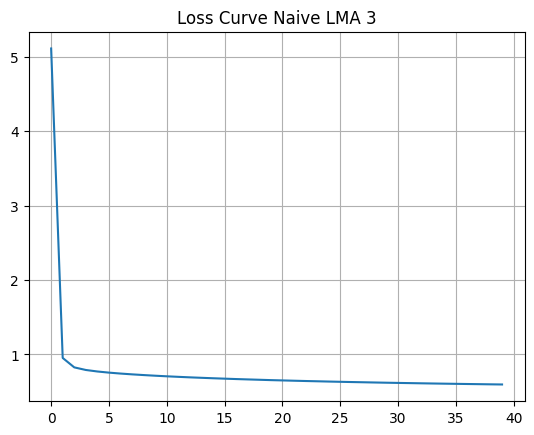

In [ ]:
plt.title("Loss Curve Naive LMA 3")
plt.plot(loss_record)
plt.grid(True)
plt.show()

In [ ]:
class NaiveLMA5 (ln.Component) :
  def __init__ (self,embed_dim ) :
    super().__init__()
    std = math.sqrt(2 / (embed_dim * 2))
    self.wg =ln.Parameter(
        tensor = ll.normal(0,std,(embed_dim,embed_dim),max_random_seed=100)
    )
    self.wo = ln.Parameter(
        tensor = ll.normal(0,std,(embed_dim,embed_dim),max_random_seed=100)
    )

    self.factor = ln.Parameter(
        tensor = ll.randn((1,1,embed_dim)) * 1e-4
    )

  def forwardpass(self,Q,K,V,mask = None) :
    scale_factor = self.factor * (K + V)
    lm = ll.matmul(Q + scale_factor,self.wg)
    score = ll.matmul(lm,K,transpose_b=True) / K.shape[-1] ** 0.5
    if mask is not None :
      score = score + mask

    score = dl.activations.softmax(score,axis=-1,keepdims=True,use_crossentropy=False)
    attn = ll.matmul(score,V)
    attn = ll.matmul(attn,self.wo)
    return attn